In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from logistic import LogisticRegression # 我封装的逻辑回归
from softmax import SoftmaxRegression # 我封装的softmax

数据读取

In [13]:
features_row=pd.read_csv('./ex4x.dat',header=None,sep=r'\s+')
labels_row=pd.read_csv('./ex4y.dat',header=None,sep=r'\s+')

数据载入

In [14]:
features=np.column_stack((features_row[0].values.tolist(),features_row[1].values.tolist()))
labels=np.array(labels_row[0].values.tolist()).reshape(-1,1)
print('{},{}'.format(features.shape,labels.shape))

(80, 2),(80, 1)


K倍交叉验证数据切分

In [15]:
def K_fold_split(data,k,test_data_index):
    data_copy=np.array(data)
    splited_datas=np.array_split(data_copy,k)
    test_data=splited_datas[test_data_index]
    train_data=[]
    for i in range(k):
        if i==test_data_index:
            continue
        train_data.extend(splited_datas[i])
    
    train_data=np.array(train_data).reshape(-1,data.shape[1])
    return test_data,train_data

三层前向神经网络

In [16]:
class ForwardNeuralNetwork:
    def __init__(self, features, labels, hidden_size):
        """
        features 为不含有偏置项1,未标准化的矩阵,行数为样本数,列数为特征数
        """

        self.features, self.means, self.stds = self.preprocessing_data(features) # 数据预处理
        self.labels = np.array(labels)

        self.sample_num = self.features.shape[0]
        self.feature_num = self.features.shape[1]
        self.type_num = self.labels.shape[1]
        self.hidden_size = hidden_size
        self.losses = []

        self.w1 = np.random.random((self.feature_num, self.hidden_size))
        self.w2 = np.random.random((self.hidden_size, self.type_num))

        self.a1 = self.features
        self.a2 = None # 权重一运算结果
        self.z2 = None # 权重一运算结果激活结果
        self.a3 = None # 权重二运算结果
        self.z3 = None # 权重二运算结果激活结果/即输出结果

    def normalize_data(self, data):# 数据标准化
        res = np.array(data)
        means = np.mean(res, axis=0)
        stds = np.std(res, axis=0)
        res = (res - means) / stds
        return res, means, stds

    def preprocessing_data(self, input):  # 数据标准化与偏置
        data, means, stds = self.normalize_data(input)
        data = np.column_stack((data, np.ones(data.shape[0])))
        return data, means, stds

    def preprocessing_test_data(self, test_data):  # 对测试数据进行标准化与添加偏置
        test_data_copy = np.array(test_data)
        test_data_copy = (test_data_copy - self.means) / self.stds
        test_data_copy = np.column_stack(
            (test_data_copy, np.ones(test_data_copy.shape[0]))
        )
        return test_data_copy

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def d_sigmoid(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def relu(self, x):
        return np.maximum(0, x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def cross_entropy_loss(self, y_pred): # 交叉熵损失函数
        ans = -np.mean(
            self.labels * np.log(y_pred) + (1 - self.labels) * np.log(1 - y_pred),
            axis=0,
        )
        return ans[0]

    def forward(self, x): # 前向传播
        self.a2 = x @ self.w1
        self.z2 = self.sigmoid(self.a2)
        # self.z2=self.relu(self.a2)
        self.a3 = self.z2 @ self.w2
        self.z3 = self.sigmoid(self.a3)
        y_pred = self.z3
        return y_pred

    def backward(self, y_pred, learning_rate, x): # 反向传播
        dloss_dypred = -self.labels/y_pred+(1-self.labels)/(1-y_pred)

        dypred_da3 = self.d_sigmoid(self.a3)
        # dypred_da3=self.d_relu(self.a3)
        
        dloss_dw2 = ((self.z2).T) @ (dypred_da3 * dloss_dypred)
        

        dz2_da2 = self.d_sigmoid(self.a2)
        # dz2_da2=self.d_relu(self.a2)
        
        dloss_dw1 = x.T @ (((dloss_dypred * dypred_da3) @ ((self.w2).T)) * dz2_da2)
        

        self.w2 = self.w2 - learning_rate * dloss_dw2
        
        self.w1 = self.w1 - learning_rate * dloss_dw1
        

    def train(self, max_epoch, learning_rate):# 模型训练
        for epoch in range(max_epoch):
            # print("--------------epoch:{}---------------".format(epoch))
            # print("features_train:{}".format(self.a1))
            lr=learning_rate
            lr=lr/(1+0.1*epoch)
            y_pred = self.forward(self.a1)
            # print("y_pred:{}".format(y_pred))
            loss = self.cross_entropy_loss(y_pred)
            # print("loss:{}".format(loss))
            self.losses.append(loss)
            self.backward(y_pred, lr, self.a1)

    def predict(self, input):  # 测试集预测
        # print("input:{}".format(input))
        input = self.preprocessing_test_data(input)
        # print("input:{}".format(input))
        prediction = self.forward(input)
        # print("prediction:{}".format(prediction))
        return prediction

    def classify(self, data, threshold=0.5):
        return np.where(data >= threshold, 1, 0)

    def compute_accuracy(self, features_test_data, labels_test_data):
        # std = self.classify(labels_test_data)
        # print("std:{}".format(std))
        prediction = self.predict(features_test_data)
        prediction=self.classify(prediction)
        # print("prediction:{}".format(prediction))
        total = labels_test_data.shape[0]
        equal_count = 0
        for i in range(total):
            if prediction[i][0] == labels_test_data[i][0]:
                equal_count += 1
        # print("equal_conut:{}".format(equal_count))
        # print("total:{}".format(total))
        return equal_count / total

进行k倍交叉验证

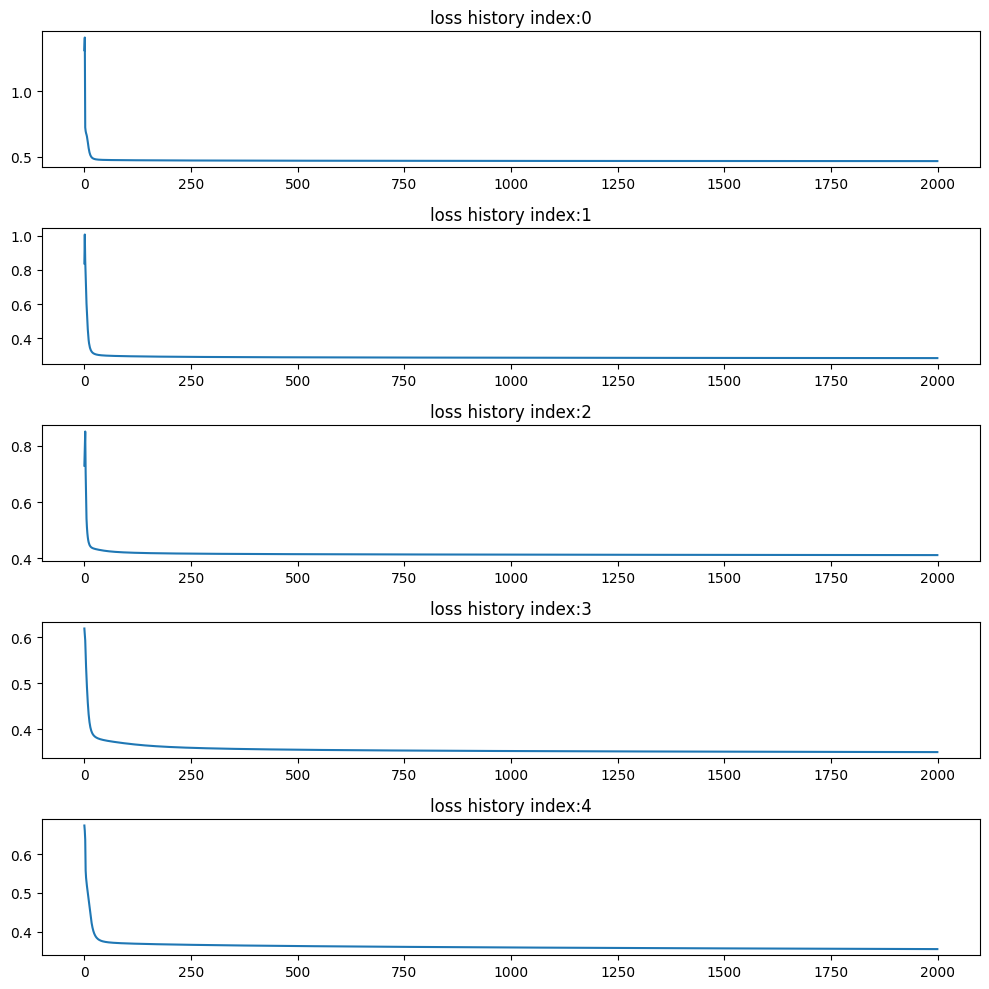

In [17]:
accuracy_history=[]
k=5
hidden_size=4
max_epoch=2000
lr=0.1
loss_fig,loss_fig_axs=plt.subplots(nrows=5,ncols=1,figsize=(10,10))
for index in range(k):
    features_test_data,features_train_data=K_fold_split(features,k,index)
    labels_test_data,labels_train_data=K_fold_split(labels,k,index)
    fnn=ForwardNeuralNetwork(features_train_data,labels_train_data,hidden_size)
    fnn.train(max_epoch,lr)
    acc=fnn.compute_accuracy(features_test_data,labels_test_data)
    
    loss_fig_axs[index].plot(fnn.losses)
    loss_fig_axs[index].set_title("loss history index:{}".format(index))
    accuracy_history.append(acc)

loss_fig.tight_layout()

上图为不同训练集的损失函数变化

In [18]:
print("-----------------FNN------------------")
for index,acc in enumerate(accuracy_history):
    print("index:{}  accuracy:{}".format(index,acc))

print("--------------average--------------")
print("average accuracy:{}".format(np.mean(accuracy_history)))

-----------------FNN------------------
index:0  accuracy:0.9375
index:1  accuracy:0.4375
index:2  accuracy:0.875
index:3  accuracy:0.75
index:4  accuracy:0.625
--------------average--------------
average accuracy:0.725


以上为不同测试集划分时，不同的训练结果所得出的预测正确率

接下来引用我封装好的logistic回归

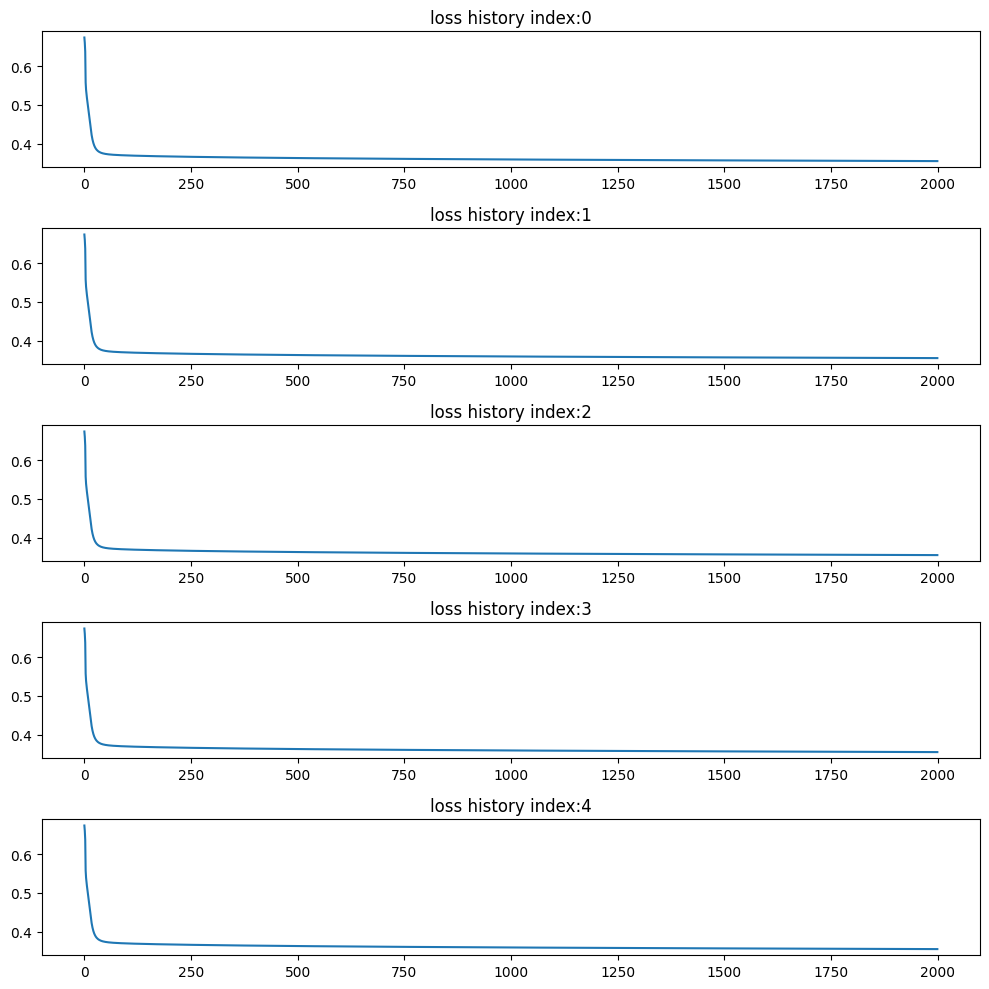

In [19]:
accuracy_history=[]
k=5
hidden_size=4
max_epoch=2000
lr=0.1
loss_fig,loss_fig_axs=plt.subplots(nrows=5,ncols=1,figsize=(10,10))
for index in range(k):
    features_test_data,features_train_data=K_fold_split(features,k,index)
    labels_test_data,labels_train_data=K_fold_split(labels,k,index)
    lgr=LogisticRegression(features_train_data,labels_train_data)
    lgr.train(max_epoch,lr)
    acc=lgr.compute_accuracy(features_test_data,labels_test_data)
    
    loss_fig_axs[index].plot(fnn.losses)
    loss_fig_axs[index].set_title("loss history index:{}".format(index))
    accuracy_history.append(acc)

loss_fig.tight_layout()

In [20]:
print("-----------------Logistic Regression------------------")
for index,acc in enumerate(accuracy_history):
    print("index:{}  accuracy:{}".format(index,acc))

print("--------------average--------------")
print("average accuracy:{}".format(np.mean(accuracy_history)))

-----------------Logistic Regression------------------
index:0  accuracy:0.9375
index:1  accuracy:0.4375
index:2  accuracy:0.875
index:3  accuracy:0.6875
index:4  accuracy:0.625
--------------average--------------
average accuracy:0.7125


然后是softmax回归

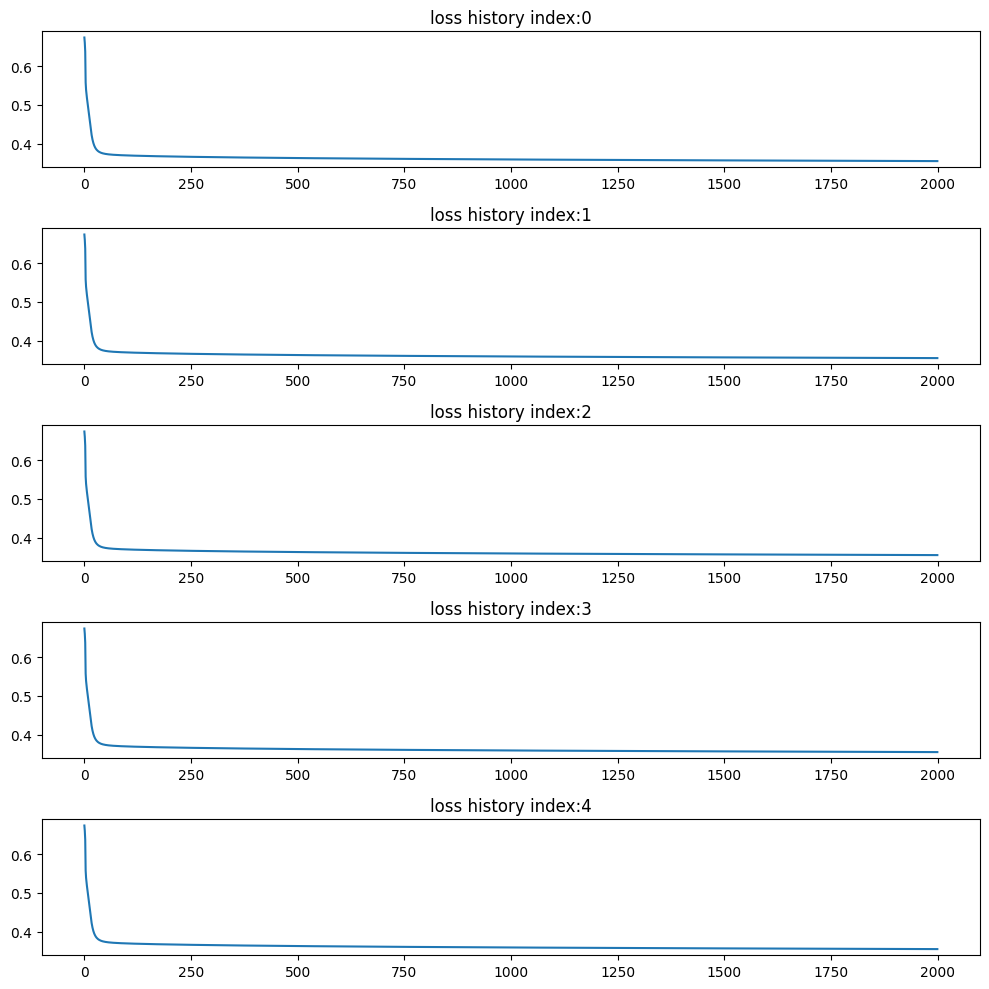

In [21]:
accuracy_history=[]
k=5
hidden_size=4
max_epoch=2000
lr=0.1
loss_fig,loss_fig_axs=plt.subplots(nrows=5,ncols=1,figsize=(10,10))
for index in range(k):
    features_test_data,features_train_data=K_fold_split(features,k,index)
    labels_test_data,labels_train_data=K_fold_split(labels,k,index)
    smr=SoftmaxRegression(features_train_data,labels_train_data)
    smr.train(max_epoch,lr)
    acc=smr.compute_accuracy(features_test_data,labels_test_data)
    
    loss_fig_axs[index].plot(fnn.losses)
    loss_fig_axs[index].set_title("loss history index:{}".format(index))
    accuracy_history.append(acc)

loss_fig.tight_layout()

In [22]:
print("-----------------Softmax Regression------------------")
for index,acc in enumerate(accuracy_history):
    print("index:{}  accuracy:{}".format(index,acc))

print("--------------average--------------")
print("average accuracy:{}".format(np.mean(accuracy_history)))

-----------------Softmax Regression------------------
index:0  accuracy:0.9375
index:1  accuracy:0.4375
index:2  accuracy:0.875
index:3  accuracy:0.6875
index:4  accuracy:0.625
--------------average--------------
average accuracy:0.7125


经过对三种模型使用同样的学习率以及迭代次数，发现在相同的情况下，三层前向神经网络的预测效果更好，并且损失会更快地收敛